This Jupyter Notebook separately analyzes the ***True Positive Rate (TPR)*** for **male** and **female** patients across multiple disease labels and models. It processes five CSV files, computes the optimal threshold using the F1 score, and evaluates TPR independently for each gender. The results are visualized in gender-specific bar plots, allowing for a clear comparison of model performance in disease detection for males and females.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [12]:
# Define disease labels
diseases = [
    "Enlarged Cardiomediastinum", "Cardiomegaly", "Lung Opacity", "Lung Lesion", 
    "Edema", "Consolidation", "Pneumonia", "Atelectasis", "Pneumothorax", 
    "Pleural Effusion", "Pleural Other", "Fracture", "Support Devices", "No Finding"
]

# Function to calculate TPR
def calculate_tpr(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tp / (tp + fn) if (tp + fn) > 0 else 0

# Function to find the best threshold based on F1 score
def find_best_threshold(y_true, y_prob):
    thresholds = np.linspace(0, 1, 100)
    best_threshold = 0
    best_f1 = 0
    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        tp = ((y_pred == 1) & (y_true == 1)).sum()
        fp = ((y_pred == 1) & (y_true == 0)).sum()
        fn = ((y_pred == 0) & (y_true == 1)).sum()
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    return best_threshold

# Function to calculate TPR by gender for a specific disease
def calculate_tpr_by_gender(df, disease):
    y_true = df[f"{disease}_ground_truth"]
    y_prob = df[f"{disease}_probability"]
    best_threshold = find_best_threshold(y_true, y_prob)
    y_pred = (y_prob >= best_threshold).astype(int)
    
    tprs = {}
    for gender in df["gender"].dropna().unique():
        gender_subset = df[df["gender"] == gender]
        if gender_subset[f"{disease}_ground_truth"].nunique() < 2 or gender_subset[f"{disease}_probability"].nunique() < 2:
            tprs[gender] = None
        else:
            y_true_gender = gender_subset[f"{disease}_ground_truth"]
            y_pred_gender = (gender_subset[f"{disease}_probability"] >= best_threshold).astype(int)
            tprs[gender] = calculate_tpr(y_true_gender, y_pred_gender)
    return tprs

# Function to process a CSV file and calculate TPRs for all diseases by gender
def process_csv(file_path):
    df = pd.read_csv(file_path)
    tpr_results = {}
    for disease in diseases:
        tpr_results[disease] = calculate_tpr_by_gender(df, disease)
    return tpr_results

In [13]:
# Define CSV file paths
csv_files = ["bl.csv", "adv.csv", "fine.csv", "ens.csv", "com.csv"]

# Process all CSV files to compute TPR
tpr_data = {csv_file: process_csv(csv_file) for csv_file in csv_files}

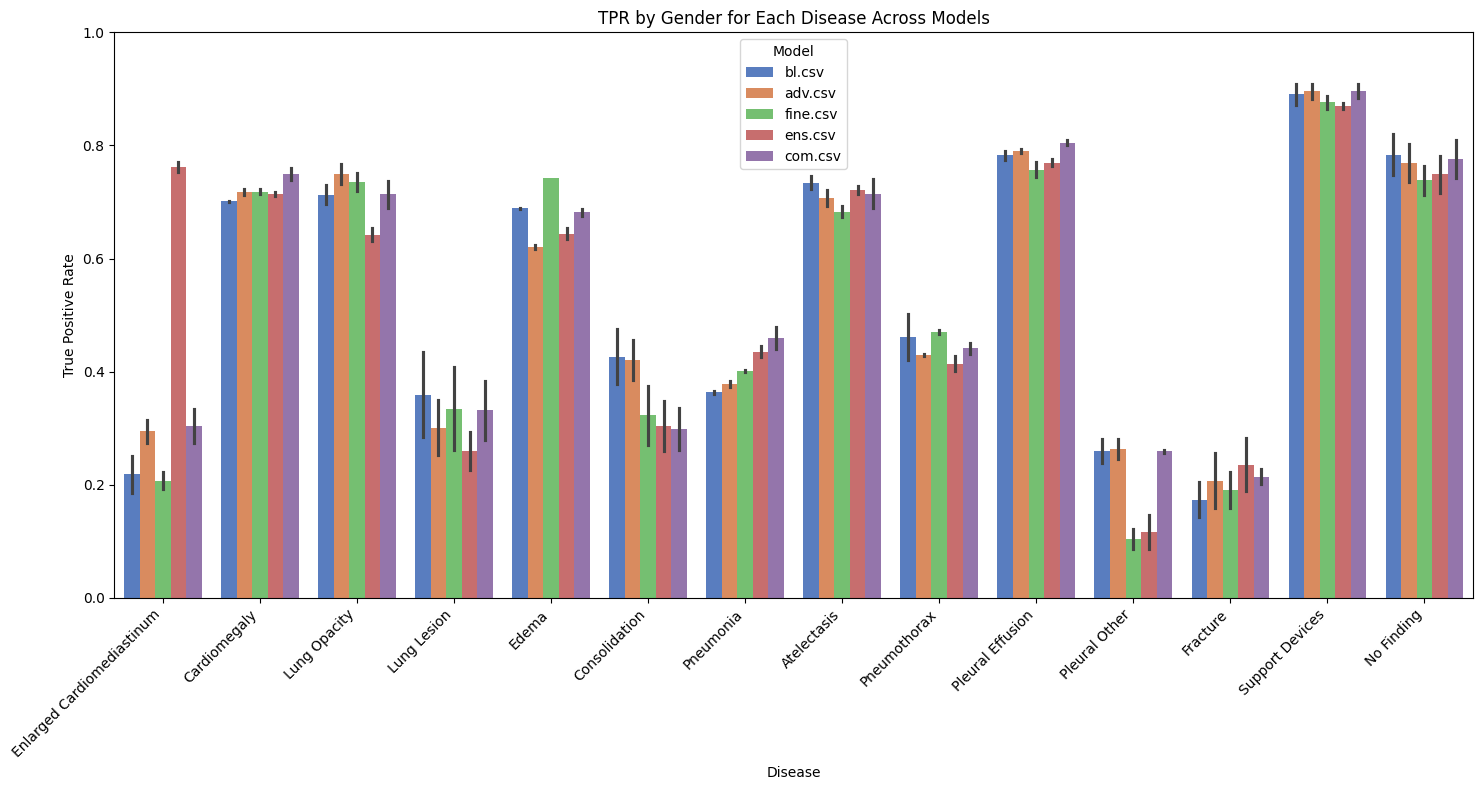

In [14]:
# Prepare data for visualization
plot_data = []
for disease in diseases:
    for csv_file in csv_files:
        for gender in ["M", "F"]:
            tpr_value = tpr_data[csv_file][disease].get(gender, None)
            if tpr_value is not None:
                plot_data.append({"Disease": disease, "Model": csv_file, "Gender": gender, "TPR": tpr_value})

# Convert to DataFrame for plotting
plot_df = pd.DataFrame(plot_data)

# Plot TPR comparison
plt.figure(figsize=(15, 8))
sns.barplot(data=plot_df, x="Disease", y="TPR", hue="Model", palette="muted")
plt.xticks(rotation=45, ha="right")
plt.title("TPR by Gender for Each Disease Across Models")
plt.ylabel("True Positive Rate")
plt.xlabel("Disease")
plt.legend(title="Model")
plt.ylim(0, 1)  # TPR ranges from 0 to 1
plt.tight_layout()
plt.show()